In [1]:
#pip install pmdarima

In [2]:
#pip install pmdarima

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pmdarima as pm
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
import statsmodels.api as sm
import math
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [4]:
df = pd.read_csv('teleco_time_series.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.6 KB


In [6]:
pd.set_option("display.max_columns", None)
df

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554
...,...,...
726,727,16.931559
727,728,17.490666
728,729,16.803638
729,730,16.194813


In [7]:
df = df.set_index(pd.date_range(start='2020-1-1', periods=df.shape[0], freq='D'))

# Drop the original 'Day' 
df.drop('Day', axis=1, inplace=True)
# Display the updated DataFrame
df

,Revenue
2020-01-01,0.000000
2020-01-02,0.000793
2020-01-03,0.825542
2020-01-04,0.320332
2020-01-05,1.082554
...,...
2021-12-27,16.931559
2021-12-28,17.490666
2021-12-29,16.803638
2021-12-30,16.194813


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2020-01-01 to 2021-12-31
Freq: D
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  731 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


In [9]:
# show sample from dataframe
n_rows=10
df.sample(n_rows, random_state=0)

,Revenue
2020-07-15,6.047722
2020-07-06,5.871569
2020-01-15,0.979732
2020-02-01,3.118231
2021-01-25,11.324020
2020-11-15,8.263694
2020-10-26,10.135351
2021-12-03,15.563935
2021-04-07,12.061822
2020-01-28,3.113270


In [10]:
df.isnull().any()

Revenue    False
dtype: bool

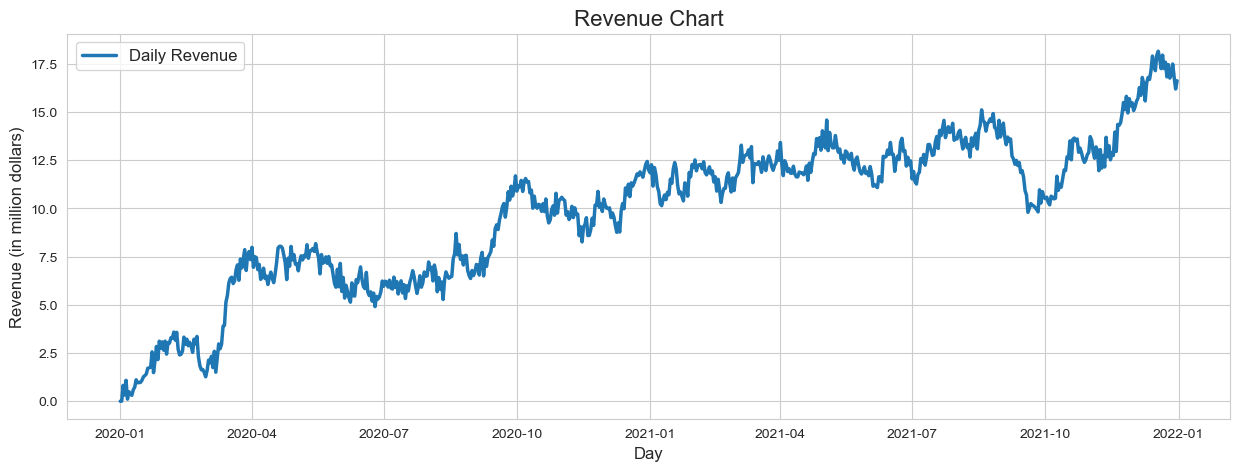

In [11]:
sns.set_style("whitegrid")

# Plotting
plt.figure(figsize=(15, 5))
sns.lineplot(data=df['Revenue'], label='Daily Revenue', linewidth=2.5)
plt.title('Revenue Chart', fontsize=16)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Revenue (in million dollars)', fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

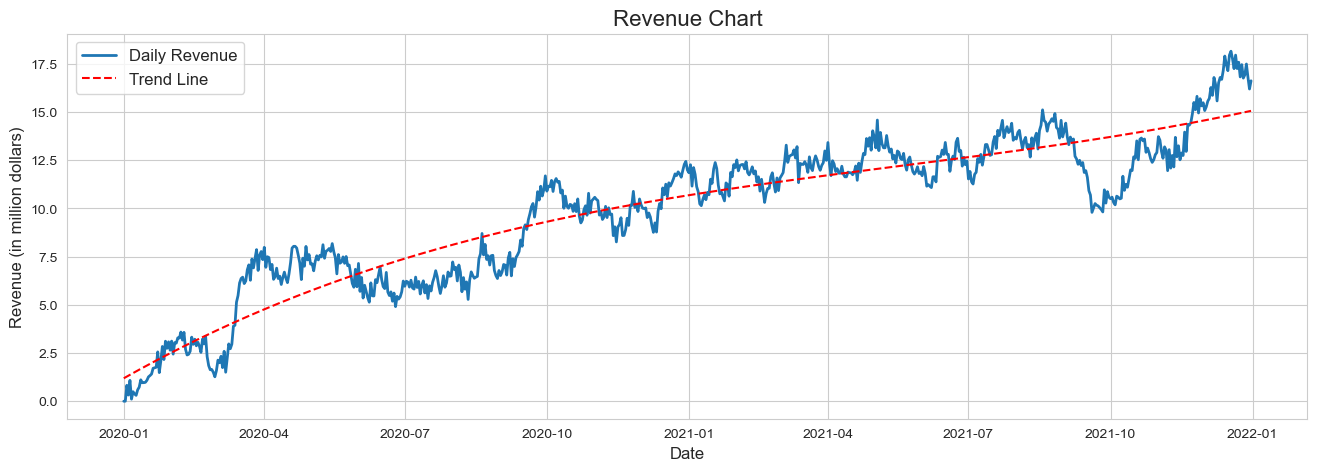

In [12]:
sns.set_style("whitegrid")

# Plotting 
plt.figure(figsize=(16, 5))
plt.title('Revenue Chart', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue (in million dollars)', fontsize=12)

# Plotting original data
sns.lineplot(data=df['Revenue'], label='Daily Revenue', linewidth=2)

# Convert timestamps to numeric values
x = mdates.date2num(df.index)

# Fit and plot the trend line
z = np.polyfit(x, df['Revenue'], 3)
p = np.poly1d(z)
plt.plot(df.index, p(x), color='red', linestyle='--', label='Trend Line')

# Adding legend
plt.legend(fontsize=12)

# Show the plot
plt.show()


In [13]:
df.to_csv('clean.csv', index=True, header=True)

<Axes: >

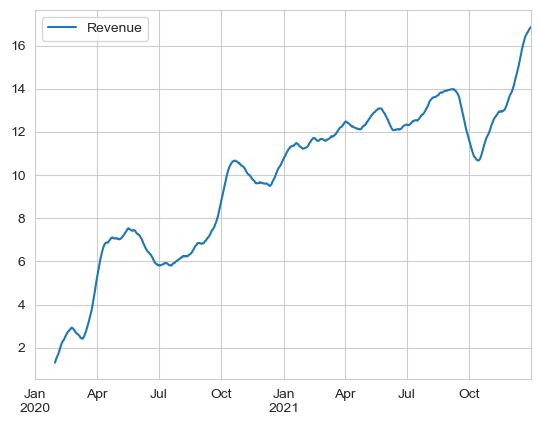

In [14]:
#sns.set_palette("husl")

# Plot the rolling mean 
rolling_mean = df.rolling(window=30).mean()
rolling_mean.plot()

In [15]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2020-01-01 to 2021-12-31
Freq: D
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  731 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


In [16]:

# Perform Augmented Dickey-Fuller test on data
adfuller_results = adfuller(df['Revenue'])

# Extract test-statistic and p-value
test_statistic = round(adfuller_results[0], 4)
p_value = round(adfuller_results[1], 8)

# Extract critical values
critical_values = adfuller_results[4]

# Print the results
print(f"The test statistic of an augmented Dickey-Fuller test on this data is {test_statistic}, which has a p-value of {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"\t{key}: {value}")


The test statistic of an augmented Dickey-Fuller test on this data is -1.9246, which has a p-value of 0.32057282
Critical Values:
	1%: -3.4393520240470554
	5%: -2.8655128165959236
	10%: -2.5688855736949163


In [17]:
#Find the proper 80/20 split

proper_split = round(len(df)* 0.80)
print(proper_split, "rows")
proper_split_date = df.iloc[[585]].index.values
print(proper_split_date)

585 rows
['2021-08-08T00:00:00.000000000']


ADF Test: Test statistic = -44.8745, p-value = 0.0
Critical values: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
Reject null hypothesis, the time series is stationary


<Axes: >

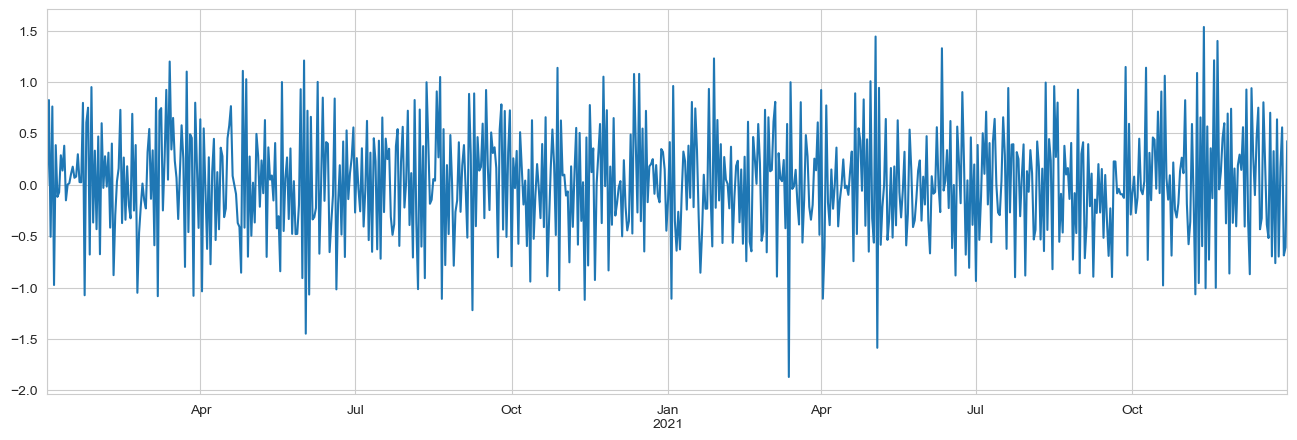

In [18]:
# Compute first difference and drop NaN values
df_diff = df.diff().dropna()

# Perform Augmented Dickey-Fuller test
adfuller_results = adfuller(df_diff['Revenue'])

# Print test results
print(f"ADF Test: Test statistic = {round(adfuller_results[0], 4)}, p-value = {round(adfuller_results[1], 8)}")
print('Critical values:', adfuller_results[4])

if adfuller_results[1]<=0.05:
    print("Reject null hypothesis, the time series is stationary")
else:
    print("Failure to reject null hypothesis, the time series is non-stationary")

# Plot revenue difference
df_diff['Revenue'].plot(figsize = [16,5])

In [19]:
# Split time series into a training set and a test set
train, test = train_test_split(df_diff, test_size=0.2, shuffle=False, random_state=369)
train

,Revenue
2020-01-02,0.000793
2020-01-03,0.824749
2020-01-04,-0.505210
2020-01-05,0.762222
2020-01-06,-0.974900
...,...
2021-08-03,0.113264
2021-08-04,-0.531705
2021-08-05,-0.437835
2021-08-06,0.422243


In [20]:
test

,Revenue
2021-08-08,-0.531923
2021-08-09,0.157387
2021-08-10,-0.644689
2021-08-11,0.995057
2021-08-12,-0.438775
...,...
2021-12-27,0.170280
2021-12-28,0.559108
2021-12-29,-0.687028
2021-12-30,-0.608824


In [21]:
# Save dataframe to CSV
train.to_csv('task1_train_clean.csv')
# Save dataframe to CSV
test.to_csv('task1_test_clean.csv')

In [22]:
# Concatenate the dataframes
combined_data = pd.concat([train, test], ignore_index=True)

# Save 
combined_data.to_csv('combined_clean.csv', index=False)

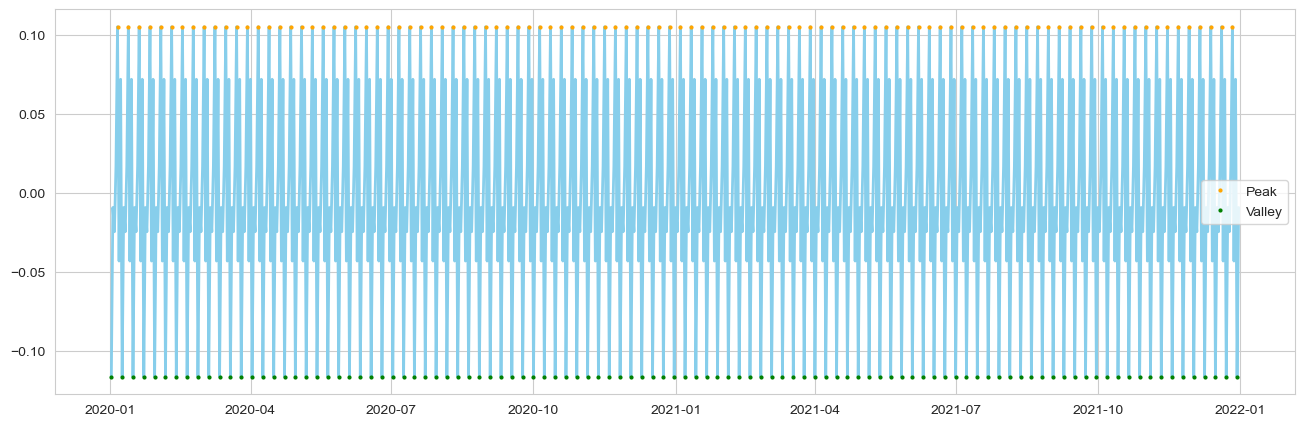

In [23]:

# Decompose the transformed data
decomposed_data = seasonal_decompose(df_diff)

sns.set_style("whitegrid")
plt.figure(figsize=[16, 5])

# Plot seasonal component of the data 
plt.plot(decomposed_data.seasonal, color='skyblue', linestyle='-', linewidth=2)

# Highlighting the peaks and valleys with different colors
peaks = decomposed_data.seasonal[decomposed_data.seasonal == decomposed_data.seasonal.max()]
valleys = decomposed_data.seasonal[decomposed_data.seasonal == decomposed_data.seasonal.min()]
plt.plot(peaks.index, peaks, marker='o', markersize=2, linestyle='', color='orange', label='Peak')
plt.plot(valleys.index, valleys, marker='o', markersize=2, linestyle='', color='green', label='Valley')

plt.legend()

plt.show()


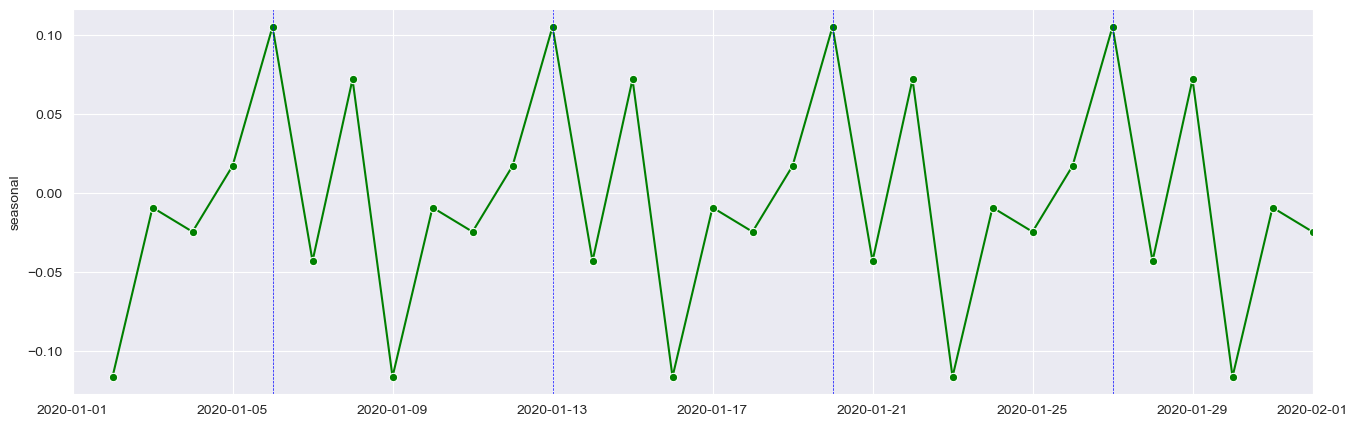

In [24]:
sns.set_style("darkgrid")
plt.figure(figsize=[16, 5])

# Plot seasonal component 
sns.lineplot(x=decomposed_data.seasonal.index, y=decomposed_data.seasonal, marker='o', color='green')

# Set x-axis limits
plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2020-02-01'))

# Highlight 
mondays = pd.date_range(start='2020-01-01', end='2020-02-01', freq='W-MON')
for monday in mondays:
    plt.axvline(x=monday, color='blue', linestyle='--', linewidth=0.5)

plt.show()



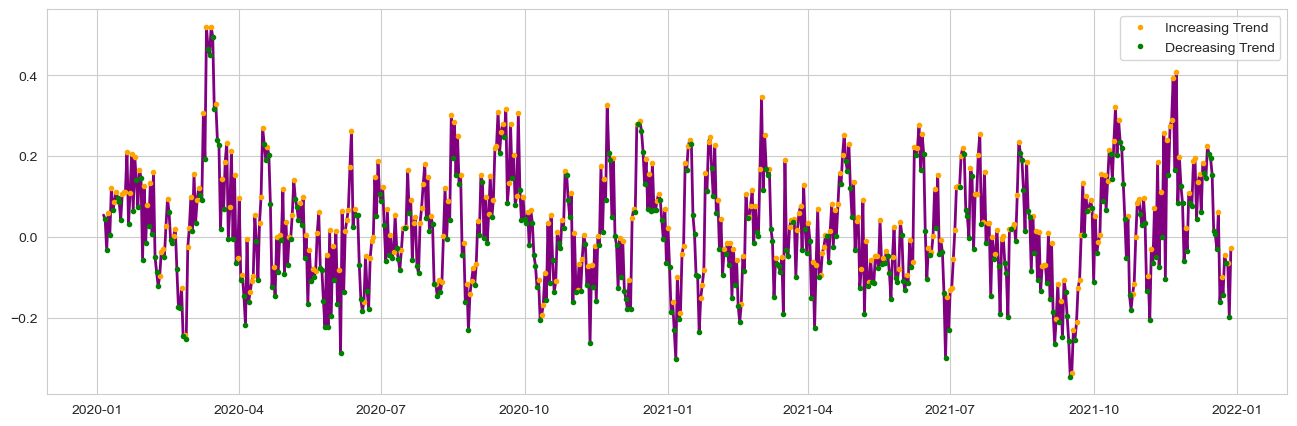

In [25]:
sns.set_style("whitegrid")
plt.figure(figsize=[16, 5])
plt.plot(decomposed_data.trend, color='purple', linewidth=2)

# Highlight the increasing trend 
increasing_trend = decomposed_data.trend[decomposed_data.trend.diff() > 0]
plt.plot(increasing_trend.index, increasing_trend, marker='o', markersize=3, linestyle='', color='orange', label='Increasing Trend')

# Highlight the decreasing trend 
decreasing_trend = decomposed_data.trend[decomposed_data.trend.diff() < 0]
plt.plot(decreasing_trend.index, decreasing_trend, marker='o', markersize=3, linestyle='', color='green', label='Decreasing Trend')

plt.legend()
plt.show()

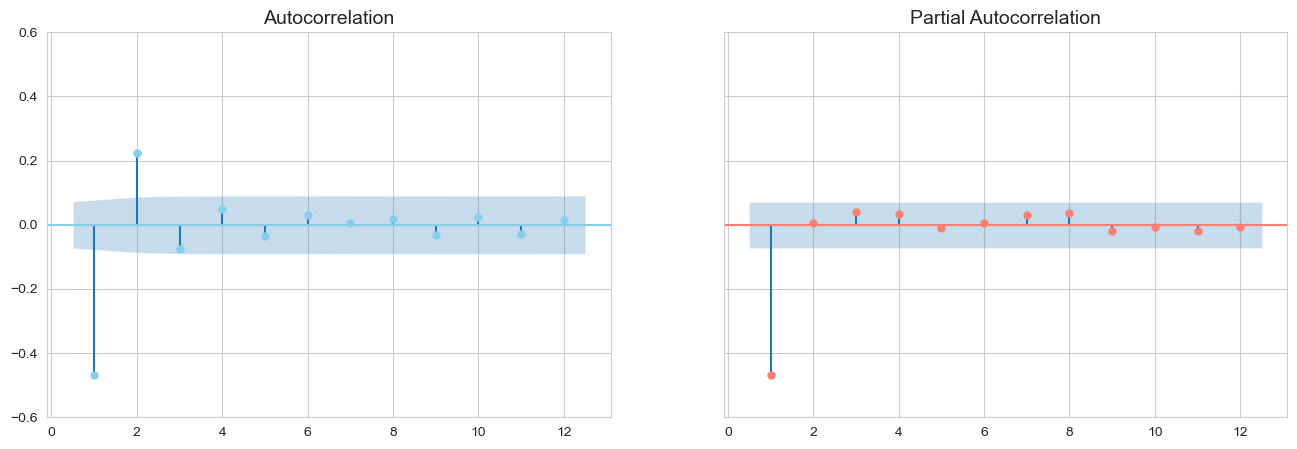

In [26]:
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,5], sharey=True)
plot_acf(df_diff, lags=12, zero=False, ax=ax1, color='skyblue')
plot_pacf(df_diff, lags=12, zero=False, ax=ax2, color='salmon')
ax1.set_title('Autocorrelation', fontsize=14)
ax2.set_title('Partial Autocorrelation', fontsize=14)

# Zoom in on y axis to see points a little more clearly
ax1.set_ylim(-0.6, 0.6)
ax2.set_ylim(-0.6, 0.6)

plt.show()


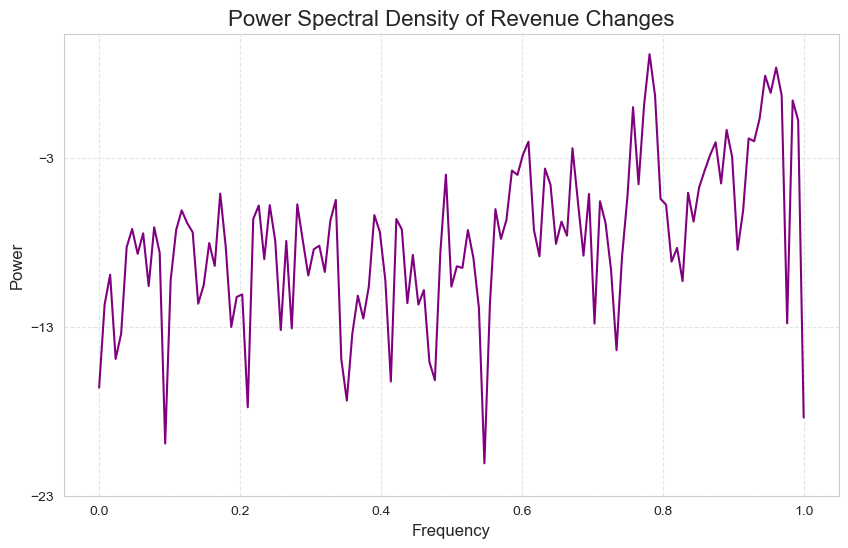

In [27]:
# Plot power spectral density 
plt.figure(figsize=[10, 6])
plt.psd(x=df_diff.Revenue, color='purple')
plt.title('Power Spectral Density of Revenue Changes', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


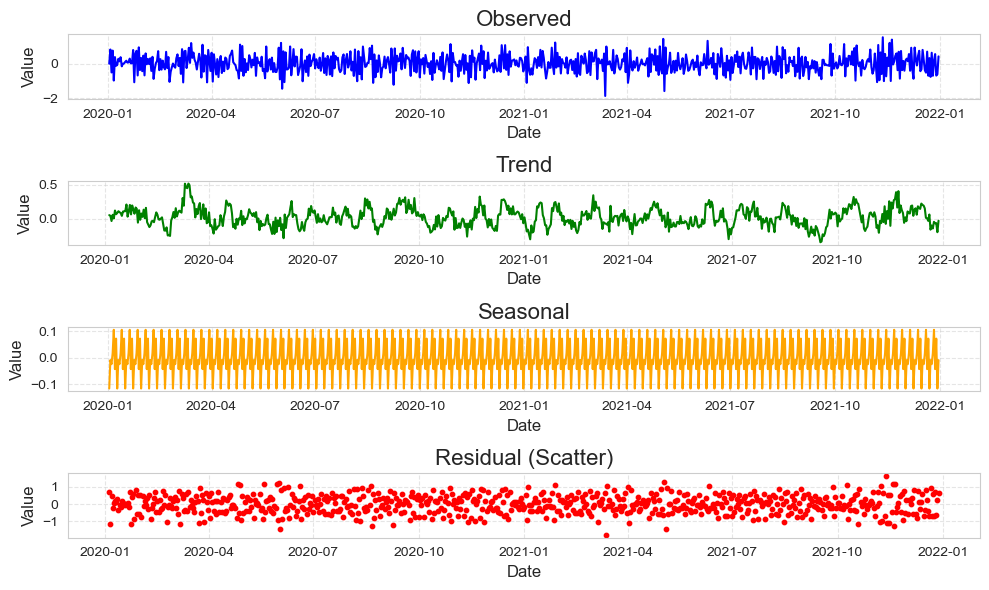

In [28]:
# Plot each component separately
plt.figure(figsize=[10, 6])

# Observed plot
plt.subplot(411)
plt.plot(decomposed_data.observed, color='blue')
plt.title('Observed', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Trend plot
plt.subplot(412)
plt.plot(decomposed_data.trend, color='green')
plt.title('Trend', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Seasonal plot
plt.subplot(413)
plt.plot(decomposed_data.seasonal, color='orange')
plt.title('Seasonal', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Residual scatter plot
plt.subplot(414)
plt.scatter(decomposed_data.resid.index, decomposed_data.resid, color='red', s=10)
plt.title('Residual (Scatter)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


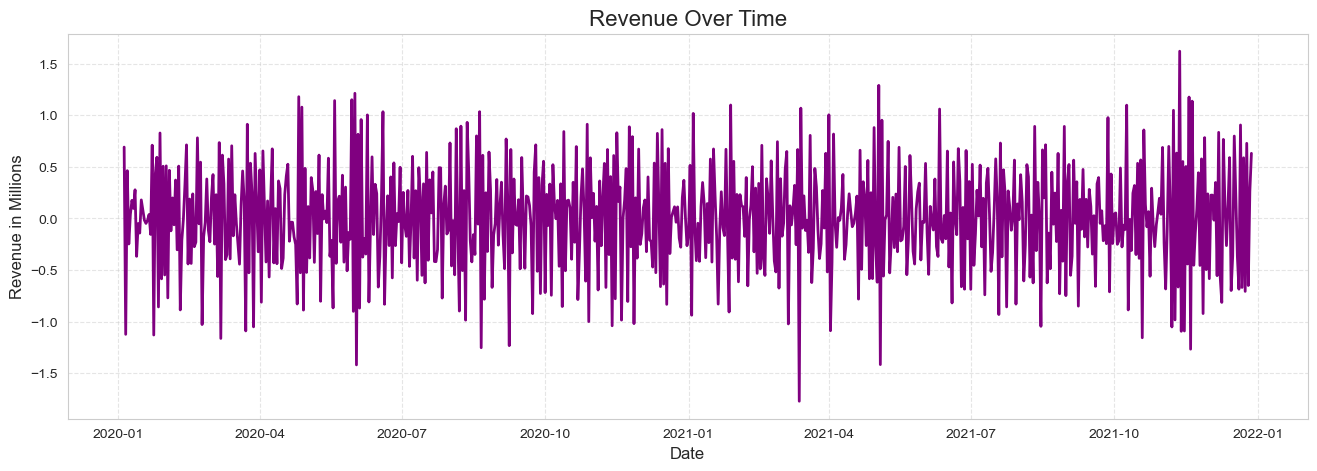

In [29]:
sns.set_style("whitegrid")

# Plotting 
plt.figure(figsize=[16, 5])
plt.plot(decomposed_data.resid, color='purple', linewidth=2)
plt.title('Revenue Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue in Millions', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [30]:
model = ARIMA(train, order=(1, 0, 0), freq='D')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -383.946
Date:                Fri, 09 Feb 2024   AIC                            773.893
Time:                        13:48:56   BIC                            787.002
Sample:                    01-02-2020   HQIC                           779.002
                         - 08-07-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0234      0.013      1.758      0.079      -0.003       0.049
ar.L1         -0.4597      0.036    -12.654      0.000      -0.531      -0.388
sigma2         0.2180      0.014     16.034      0.000       0.191       0.245
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.84
Prob(Q):                              0.96   Prob(JB):                         0.40
Heteroskedasticity (H):               0.97   Skew:                            -0.08
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
tol = auto_arima(train['Revenue'], 
        trace=True, supress_warings=True,
                max_p=30, max_q=30, max_order=30,
                     stepwise=True,
                     seasonal=False)
print(tol.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=778.818, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=909.948, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=774.990, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=801.099, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=776.989, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=776.989, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=778.497, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=773.893, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=910.790, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=775.886, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=775.888, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=799.464, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=777.694, Time=0.80 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 2.680 seconds
                               SARI

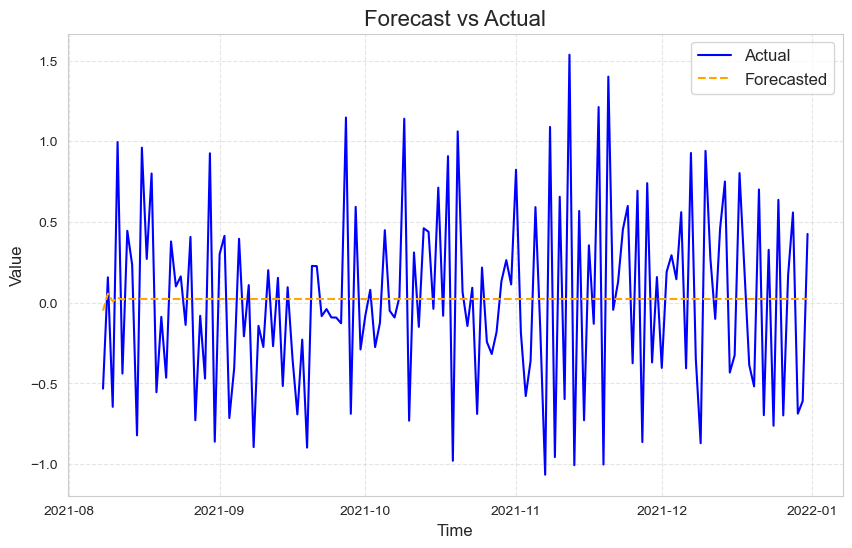

In [32]:
forecasted = results.get_prediction(start = 584, end = 729, dynamic = True)
# Plotting the original test data and the forecasted values
plt.figure(figsize=(10, 6))

# Plot the original test data
plt.plot(test, color='blue', label='Actual')

# Plot the forecasted values
plt.plot(forecasted.predicted_mean, color='orange', linestyle='--', label='Forecasted')

plt.title('Forecast vs Actual', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Value', fontsize=12)

plt.legend(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)

plt.show()


In [44]:
second_model = ARIMA(df['Revenue'], order=(1, 0, 0), freq='D')
sresults = second_model.fit()
sresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  731
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -582.531
Date:                Fri, 09 Feb 2024   AIC                           1171.061
Time:                        14:08:56   BIC                           1184.844
Sample:                    01-01-2020   HQIC                          1176.379
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4634      2.606      3.632      0.000       4.357      14.570
ar.L1          0.9945      0.004    243.683      0.000       0.986       1.002
sigma2         0.2864      0.016     17.783      0.000       0.255       0.318
===================================================================================
Ljung-Box (L1) (Q):                 159.77   Jarque-Bera (JB):                 2.13
Prob(Q):                              0.00   Prob(JB):                         0.35
Heteroskedasticity (H):               1.02   Skew:                            -0.03
Prob(H) (two-sided):                  0.87   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
prediction = sresults.get_prediction(start= pd.to_datetime('2021-12-28'), end=pd.to_datetime('2022-03-31'), dynamic = False)
prediction_ci = prediction.conf_int()
prediction_ci.head()

,lower Revenue,upper Revenue
2021-12-28,15.841311,17.939214
2021-12-29,16.397327,18.495230
2021-12-30,15.714097,17.812001
2021-12-31,15.108640,17.206543
2022-01-01,15.532269,17.630172


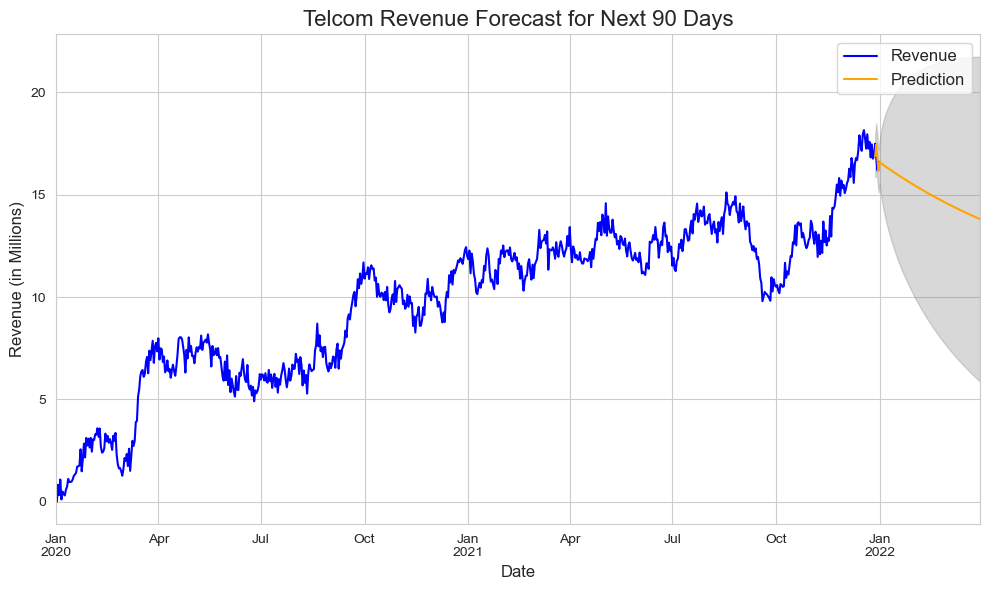

In [46]:
# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Plot observed data
df.plot(ax=ax, label='Observed', color='blue')

# Plot predicted mean
prediction.predicted_mean.plot(ax=ax, label='Prediction', color='orange')

# Fill confidence interval
ax.fill_between(prediction_ci.index, prediction_ci.iloc[:, 0], prediction_ci.iloc[:, 1], color='gray', alpha=0.3)

# Set labels and title
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel('Revenue (in Millions)', fontsize=12)
ax.set_title('Telcom Revenue Forecast for Next 90 Days', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [47]:
#MSE and RMSE
hol = prediction.predicted_mean
dol = df.Revenue

mse = ((hol - dol) ** 2).mean()
rmse = np.sqrt(mse)
print('Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

Mean Squared Error of our forecasts is 0.33
Root Mean Squared Error of our forecasts is 0.57


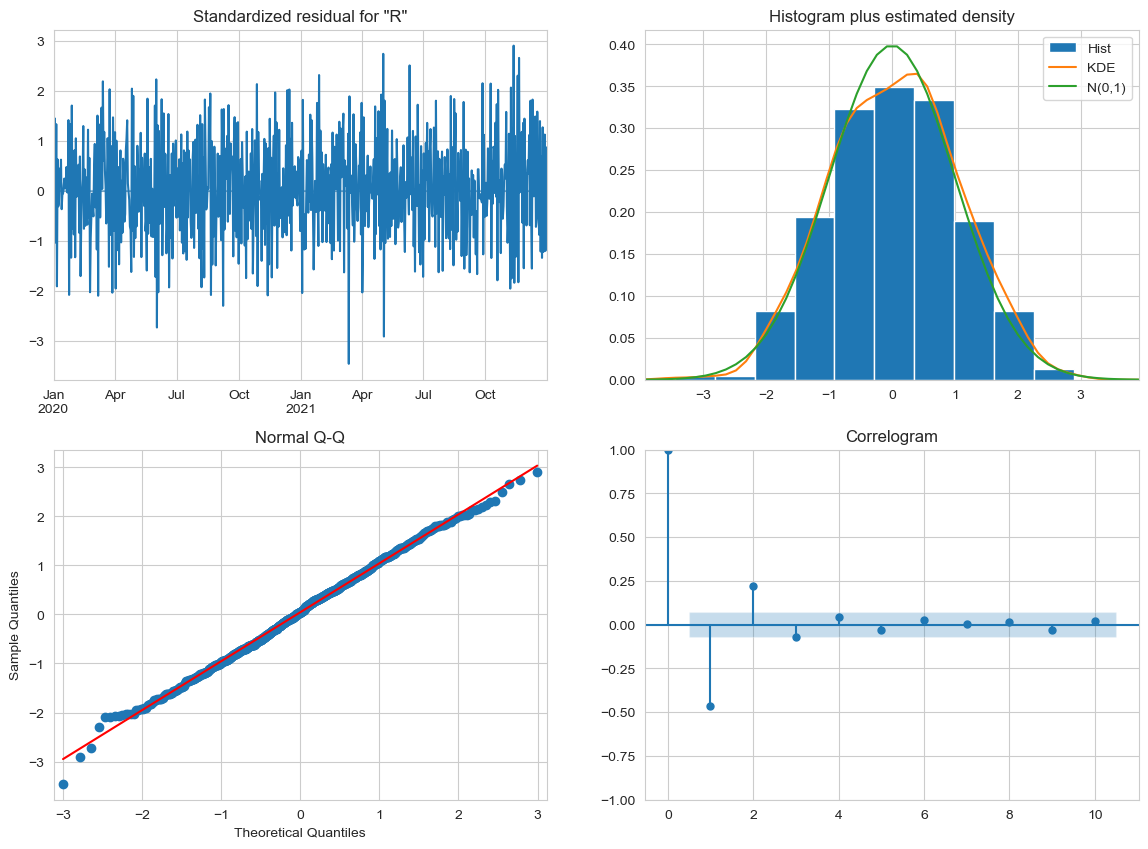

In [48]:
sresults.plot_diagnostics(figsize=(14,10))
plt.show()